# Lending Club Borrower Loan Status Classification


In this project I will perform **mutli-class classification** using **Random Forest** to classier a potential loan borrower's loan status if his or her loan is allowed. This project is based on a dataset of all loans issued through Lending Club platform from 2007 to 2012.  

## Step 1: Load and explore the dataset

In [1]:
## Import packages
library(ggplot2)
library(repr)
library(dplyr)
library(gridExtra)
options(repr.plot.width=4, repr.plot.height=4)
#install.packages("MLmetrics", repos='http://cran.us.r-project.org')
#install.packages("e1071", repos='http://cran.us.r-project.org')
library(caret)
library(MASS)
library(randomForest)
library(MLmetrics)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: lattice

Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:gridExtra':

    combine

The following object is masked from 'package:dplyr':

    combine

The following object is masked from 'package:ggplot2':

    margin


Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall



In [2]:
credit = read.csv('LoanStats3a.csv', header=TRUE, stringsAsFactors=FALSE)
str(credit)
head(credit)

'data.frame':	42542 obs. of  145 variables:
 $ id                                        : chr  "" "" "" "" ...
 $ member_id                                 : logi  NA NA NA NA NA NA ...
 $ loan_amnt                                 : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt                               : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt_inv                           : num  4975 2500 2400 10000 3000 ...
 $ term                                      : chr  " 36 months" " 60 months" " 36 months" " 36 months" ...
 $ int_rate                                  : chr  "10.65%" "15.27%" "15.96%" "13.49%" ...
 $ installment                               : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                                     : chr  "B" "C" "C" "C" ...
 $ sub_grade                                 : chr  "B2" "C4" "C5" "C1" ...
 $ emp_title                                 : chr  "" "Ryder" "" "AIR RESOURCES BOARD

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
,NA,5000,5000,4975,36 months,10.65%,162.87,B,B2,...,NA,,Cash,N,,,,NA,NA,NA
,NA,2500,2500,2500,60 months,15.27%,59.83,C,C4,...,NA,,Cash,N,,,,NA,NA,NA
,NA,2400,2400,2400,36 months,15.96%,84.33,C,C5,...,NA,,Cash,N,,,,NA,NA,NA
,NA,10000,10000,10000,36 months,13.49%,339.31,C,C1,...,NA,,Cash,N,,,,NA,NA,NA
,NA,3000,3000,3000,60 months,12.69%,67.79,B,B5,...,NA,,Cash,N,,,,NA,NA,NA
,NA,5000,5000,5000,36 months,7.90%,156.46,A,A4,...,NA,,Cash,N,,,,NA,NA,NA


I look into this dataset for the first time and find something useful for future feature selection.

- The field **loan_status** should be considered as the label. 
- The three fields **loan_amnt**, **funded_amnt** and **funded_amnt_inv** have simliar values for each instance.
- The fields **grade** and **sub_grade** contained simliar information, but **sub_grade** is more ditailed.
- The fields **earliest_cr_lin**, **issue_d** should be tansfered to Date type if interested.
- Some fields works as indexes, and should be delected, like **id**, **member_id**, **url** ,et al.
- Some fields contains strings, and are hard to transform to numeric or categorical features, like **emp_title**, **desc** ,et al.. Although they may contain information to determine if the loan will be fully paid, I will skip these fields.
- The field **payment_plan** only contains one value, so it should be deleted.
- Some fields describe the current loan payment situation, such as **total_pymnt**, **last_pymnt_d** ,et al.. These fields should be ignored, because we only think about potential loan borrowers.
- Some fields has sparse values and should delete, such as **annual_inc_joint**, et al.

Therefore, I select interested columns from the data.

In [4]:
selected_columns <- c('loan_status', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
                     'grade','emp_length', 'home_ownership', 'annual_inc', 'verification_status',
                      'purpose', 'dti', 'delinq_2yrs',  'inq_last_6mths',
                     'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
                     'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv')
credit <- credit[,selected_columns]

In [5]:
head(credit)
str(credit)

loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,...,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv
Fully Paid,5000,5000,4975,36 months,10.65%,162.87,B,10+ years,RENT,...,NA,NA,3,0,13648,83.70%,9,f,0,0
Charged Off,2500,2500,2500,60 months,15.27%,59.83,C,< 1 year,RENT,...,NA,NA,3,0,1687,9.40%,4,f,0,0
Fully Paid,2400,2400,2400,36 months,15.96%,84.33,C,10+ years,RENT,...,NA,NA,2,0,2956,98.50%,10,f,0,0
Fully Paid,10000,10000,10000,36 months,13.49%,339.31,C,10+ years,RENT,...,35,NA,10,0,5598,21%,37,f,0,0
Fully Paid,3000,3000,3000,60 months,12.69%,67.79,B,1 year,RENT,...,38,NA,15,0,27783,53.90%,38,f,0,0
Fully Paid,5000,5000,5000,36 months,7.90%,156.46,A,3 years,RENT,...,NA,NA,9,0,7963,28.30%,12,f,0,0


'data.frame':	42542 obs. of  26 variables:
 $ loan_status           : chr  "Fully Paid" "Charged Off" "Fully Paid" "Fully Paid" ...
 $ loan_amnt             : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt           : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt_inv       : num  4975 2500 2400 10000 3000 ...
 $ term                  : chr  " 36 months" " 60 months" " 36 months" " 36 months" ...
 $ int_rate              : chr  "10.65%" "15.27%" "15.96%" "13.49%" ...
 $ installment           : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                 : chr  "B" "C" "C" "C" ...
 $ emp_length            : chr  "10+ years" "< 1 year" "10+ years" "10+ years" ...
 $ home_ownership        : chr  "RENT" "RENT" "RENT" "RENT" ...
 $ annual_inc            : num  24000 30000 12252 49200 80000 ...
 $ verification_status   : chr  "Verified" "Source Verified" "Not Verified" "Source Verified" ...
 $ purpose               : chr  "credit_card" 

## Step 2 : Prepare data

### remove duplicate instances and instances with wrong label 


In [6]:
credit <- filter(credit, loan_status!='')
credit$loan_status <- as.factor(credit$loan_status)
summary(credit$loan_status)
credit = distinct(credit)
dim(credit)

Charged Off 
                                               5670 
Does not meet the credit policy. Status:Charged Off 
                                                761 
 Does not meet the credit policy. Status:Fully Paid 
                                               1988 
                                         Fully Paid 
                                              34116

[1] 42535    26

### Change type of date feautres, precentage features
1 change type of date feautres, precentage features.
2 Complete default value of some features.
2 Clean missing values or Remove features with too many missing value. 

In [7]:
#credit$int_rate<-as.character(credit$int_rate)
credit$int_rate<-as.numeric(sub("%", "", credit$int_rate))/100
credit$int_rate[1:5]
#credit$revol_util<-as.character(credit$revol_util)
credit$revol_util<-as.numeric(sub("%", "", credit$revol_util))/100
credit$revol_util[1:5]

[1] 0.1065 0.1527 0.1596 0.1349 0.1269

[1] 0.837 0.094 0.985 0.210 0.539

### Prepare categorical features
- Change data type into factors.
- Revise factors' levels to obey R language's naming rule.
- Aggregate features with too may levels.

In [8]:
names(credit)
str(credit)

[1] "loan_status"            "loan_amnt"              "funded_amnt"           
 [4] "funded_amnt_inv"        "term"                   "int_rate"              
 [7] "installment"            "grade"                  "emp_length"            
[10] "home_ownership"         "annual_inc"             "verification_status"   
[13] "purpose"                "dti"                    "delinq_2yrs"           
[16] "inq_last_6mths"         "mths_since_last_delinq" "mths_since_last_record"
[19] "open_acc"               "pub_rec"                "revol_bal"             
[22] "revol_util"             "total_acc"              "initial_list_status"   
[25] "out_prncp"              "out_prncp_inv"

'data.frame':	42535 obs. of  26 variables:
 $ loan_status           : Factor w/ 4 levels "Charged Off",..: 4 1 4 4 4 4 4 4 1 1 ...
 $ loan_amnt             : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt           : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt_inv       : num  4975 2500 2400 10000 3000 ...
 $ term                  : chr  " 36 months" " 60 months" " 36 months" " 36 months" ...
 $ int_rate              : num  0.106 0.153 0.16 0.135 0.127 ...
 $ installment           : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                 : chr  "B" "C" "C" "C" ...
 $ emp_length            : chr  "10+ years" "< 1 year" "10+ years" "10+ years" ...
 $ home_ownership        : chr  "RENT" "RENT" "RENT" "RENT" ...
 $ annual_inc            : num  24000 30000 12252 49200 80000 ...
 $ verification_status   : chr  "Verified" "Source Verified" "Not Verified" "Source Verified" ...
 $ purpose               : chr  "credit_card" "car" "s

In [9]:
#Change data type into factors.
credit$term <- as.factor(credit$term)
credit$grade <- as.factor(credit$grade)
credit$emp_length  <- as.factor(credit$emp_length )
credit$home_ownership  <- as.factor(credit$home_ownership )
credit$verification_status  <- as.factor(credit$verification_status )
credit$purpose  <- as.factor(credit$purpose )
credit$delinq_2yrs <- as.numeric(credit$delinq_2yrs)
credit$revol_bal <- as.numeric(credit$revol_bal)
credit$total_acc <- as.numeric(credit$total_acc)
credit$initial_list_status   <- as.factor(credit$initial_list_status)
str(credit)

Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"Warning message in eval(expr, envir, enclos):
"NAs introduced by coercion"

'data.frame':	42535 obs. of  26 variables:
 $ loan_status           : Factor w/ 4 levels "Charged Off",..: 4 1 4 4 4 4 4 4 1 1 ...
 $ loan_amnt             : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt           : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt_inv       : num  4975 2500 2400 10000 3000 ...
 $ term                  : Factor w/ 2 levels " 36 months"," 60 months": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate              : num  0.106 0.153 0.16 0.135 0.127 ...
 $ installment           : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                 : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ emp_length            : Factor w/ 12 levels "< 1 year","1 year",..: 3 1 3 3 2 5 10 11 6 1 ...
 $ home_ownership        : Factor w/ 5 levels "MORTGAGE","NONE",..: 5 5 5 5 5 5 5 5 4 5 ...
 $ annual_inc            : num  24000 30000 12252 49200 80000 ...
 $ verification_status   : Factor w/ 3 levels "Not Verified",..

In [10]:
#Revise factors' levels to obey R language's naming rule.
levels(credit$loan_status) <- c('ChargedOff', 'ChargedOff_unqualified', 'FullyPaid_unqualified', 'FullyPaid')
levels(credit$term) <- c('36m','60m')
levels(credit$emp_length) <- c('less1y','1y','more10y','2y','3y','4y','5y','6y','7y','8y','9y','na')
levels(credit$verification_status) <- c('NotVerified', 'SourceVerified', 'Verified')
levels(credit$purpose)[11] <- 'family_support'

In [12]:
# Aggregate features with too may levels.
length_categories = c('less1y' = 'short', '1y' = 'short', 'more10y' = 'long', '2y' = 'short','3y' = 'short',
           '4y' = 'medium','5y' = 'medium','6y' = 'medium',
           '7y' = 'long','8y' = 'long','9y' = 'long', 'na' = 'na')

out = rep('i', length.out = nrow(credit))
i = 1
for(x in credit[,'emp_length']){
    out[i] = length_categories[[x]]
    i = i + 1
}
credit[,'emp_length'] = out

table(credit[,'emp_length'])

ERROR: Error in length_categories[[x]]: subscript out of bounds


The column of **purpose** also has many levels, which may largly incresing the computing complexity. However, it's hard to aggergate to less levels. I will pay an attention to see if it is crucial to determine the loan status. If not, the feature will not be used any more.


### Complete default value of some features.

In [14]:
default_col <- c('mths_since_last_delinq','mths_since_last_record')
new_default_col <- credit[,default_col]
new_default_col[is.na(new_default_col)] <- 0
credit[,default_col] <- new_default_col

### Clean missing values and remove features with too many missing value

In [15]:
 lapply(credit, function(x){any(is.na(x))})

$loan_status
[1] FALSE

$loan_amnt
[1] FALSE

$funded_amnt
[1] FALSE

$funded_amnt_inv
[1] FALSE

$term
[1] FALSE

$int_rate
[1] FALSE

$installment
[1] FALSE

$grade
[1] FALSE

$emp_length
[1] FALSE

$home_ownership
[1] FALSE

$annual_inc
[1] TRUE

$verification_status
[1] FALSE

$purpose
[1] FALSE

$dti
[1] FALSE

$delinq_2yrs
[1] TRUE

$inq_last_6mths
[1] TRUE

$mths_since_last_delinq
[1] FALSE

$mths_since_last_record
[1] FALSE

$open_acc
[1] TRUE

$pub_rec
[1] TRUE

$revol_bal
[1] TRUE

$revol_util
[1] TRUE

$total_acc
[1] TRUE

$initial_list_status
[1] FALSE

$out_prncp
[1] FALSE

$out_prncp_inv
[1] FALSE

In [16]:
col_missvalue <- c('annual_inc','delinq_2yrs','inq_last_6mths','open_acc','pub_rec','revol_bal','revol_util','total_acc')
credit <- credit[complete.cases(credit[,col_missvalue]),]
str(credit)

'data.frame':	42444 obs. of  26 variables:
 $ loan_status           : Factor w/ 4 levels "ChargedOff","ChargedOff_unqualified",..: 4 1 4 4 4 4 4 4 1 1 ...
 $ loan_amnt             : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt           : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt_inv       : num  4975 2500 2400 10000 3000 ...
 $ term                  : Factor w/ 2 levels "36m","60m": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate              : num  0.106 0.153 0.16 0.135 0.127 ...
 $ installment           : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                 : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ emp_length            : chr  "long" "short" "long" "long" ...
 $ home_ownership        : Factor w/ 5 levels "MORTGAGE","NONE",..: 5 5 5 5 5 5 5 5 4 5 ...
 $ annual_inc            : num  24000 30000 12252 49200 80000 ...
 $ verification_status   : Factor w/ 3 levels "NotVerified",..: 3 2 1 2 2 2 1 2 2 3 .

## Feature engineering and selection

###  remove features with low variety

In [17]:
table(credit$initial_list_status)
summary(credit$out_prncp)
summary(credit$out_prncp_inv)
cols_lowvari <- c('initial_list_status','out_prncp','out_prncp_inv')
credit[,cols_lowvari] <- NULL



    0     f 
    0 42444 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 

In [18]:
str(credit)

'data.frame':	42444 obs. of  23 variables:
 $ loan_status           : Factor w/ 4 levels "ChargedOff","ChargedOff_unqualified",..: 4 1 4 4 4 4 4 4 1 1 ...
 $ loan_amnt             : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt           : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ funded_amnt_inv       : num  4975 2500 2400 10000 3000 ...
 $ term                  : Factor w/ 2 levels "36m","60m": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate              : num  0.106 0.153 0.16 0.135 0.127 ...
 $ installment           : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                 : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ emp_length            : chr  "long" "short" "long" "long" ...
 $ home_ownership        : Factor w/ 5 levels "MORTGAGE","NONE",..: 5 5 5 5 5 5 5 5 4 5 ...
 $ annual_inc            : num  24000 30000 12252 49200 80000 ...
 $ verification_status   : Factor w/ 3 levels "NotVerified",..: 3 2 1 2 2 2 1 2 2 3 .

# Step 3: Data visualization and exploratory data analysis 

### Vusualize class separation by numeric features

I use violin plots to examine the separation of label cases by numeric features. Compared to the box plots, violin plots provide more detail about the numeric feature's distribution.

In [19]:
num_cols <- c('loan_amnt', 'funded_amnt', 'funded_amnt_inv','int_rate', 'installment', 
              'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
              'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
              'total_acc' )
categerical_cols <- c('term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose')

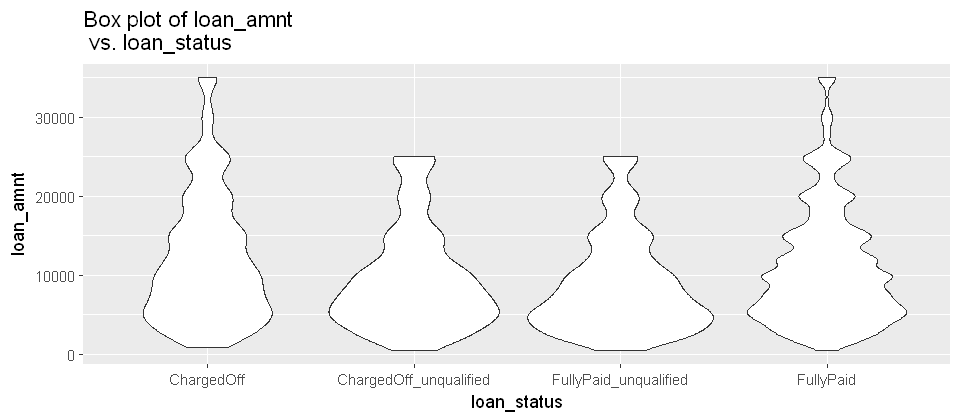

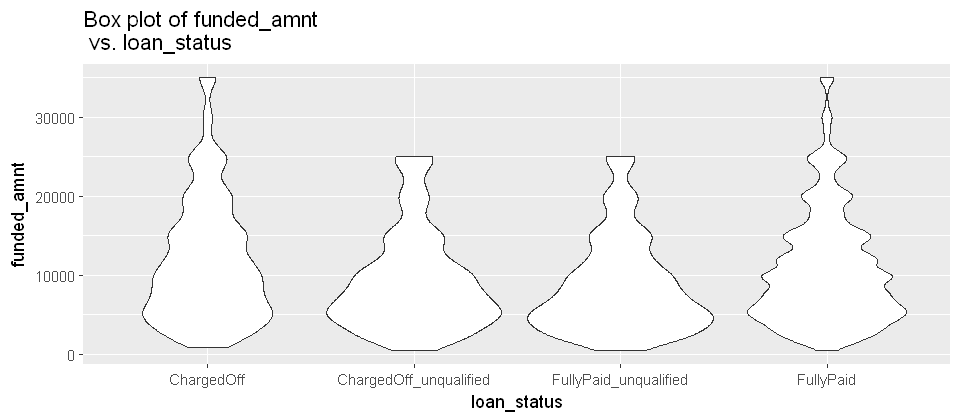

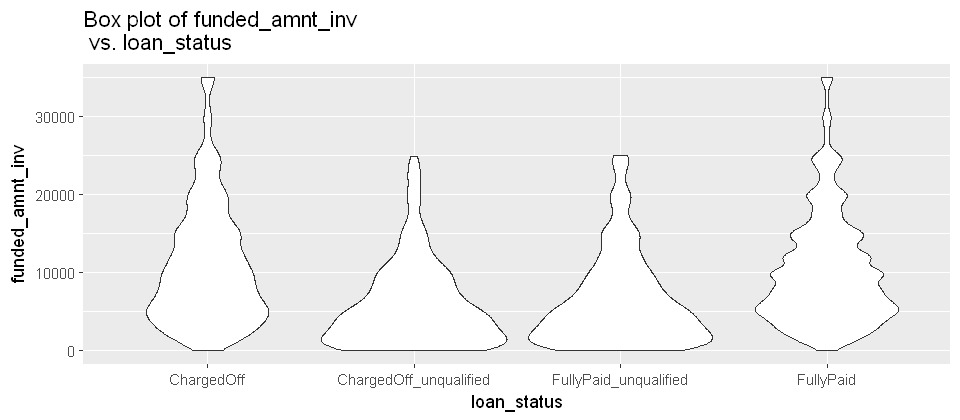

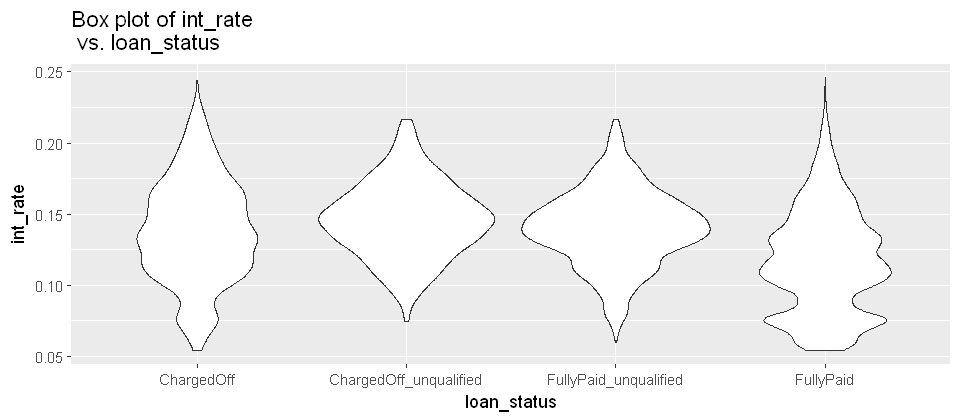

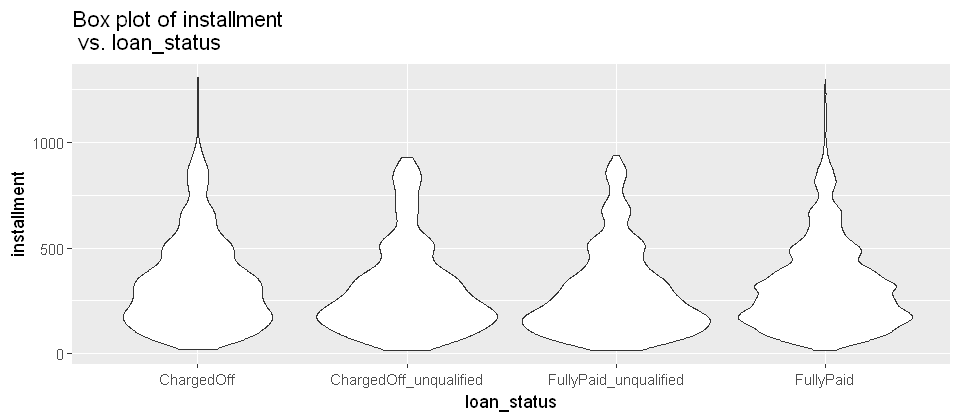

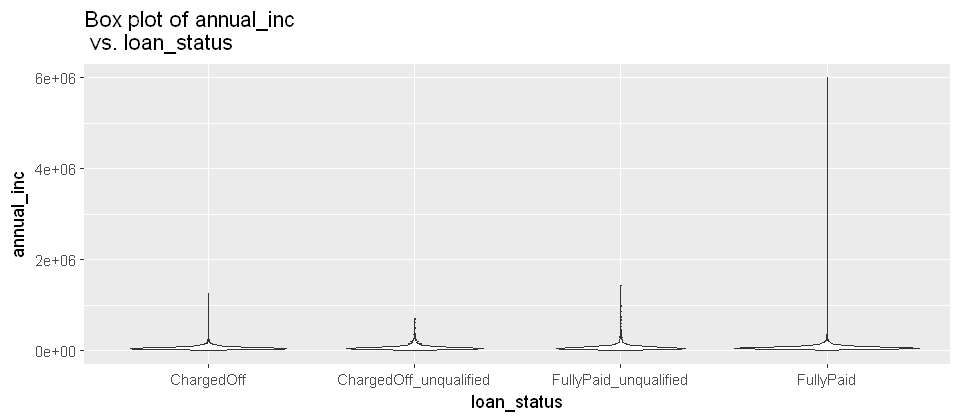

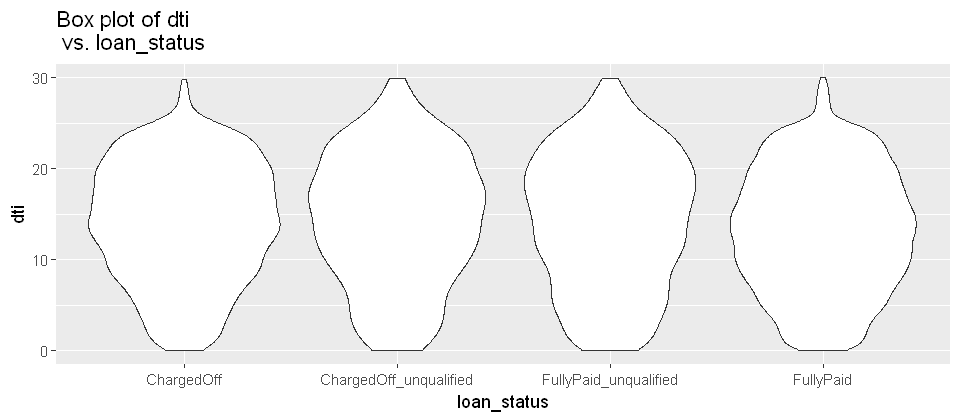

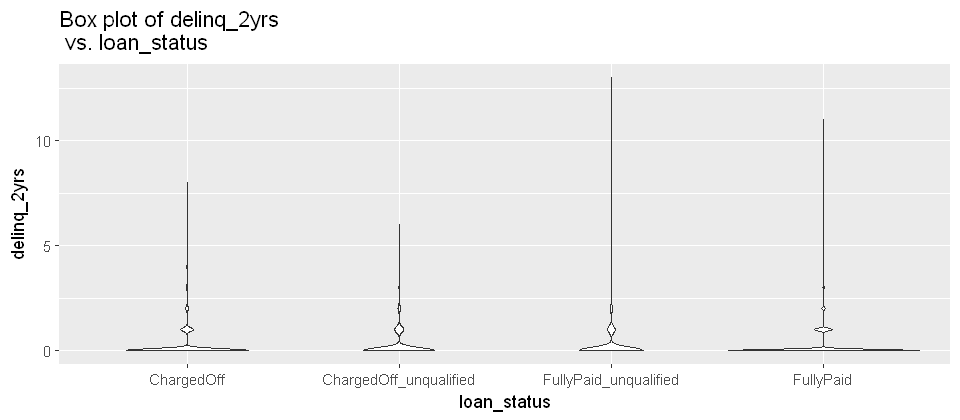

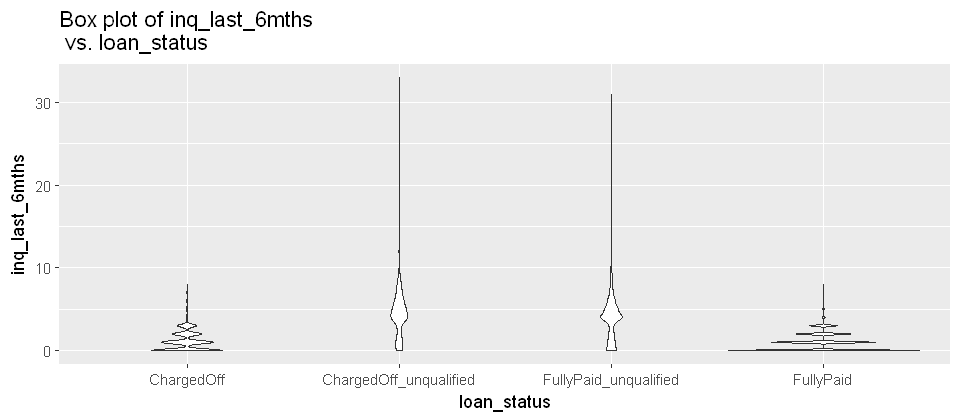

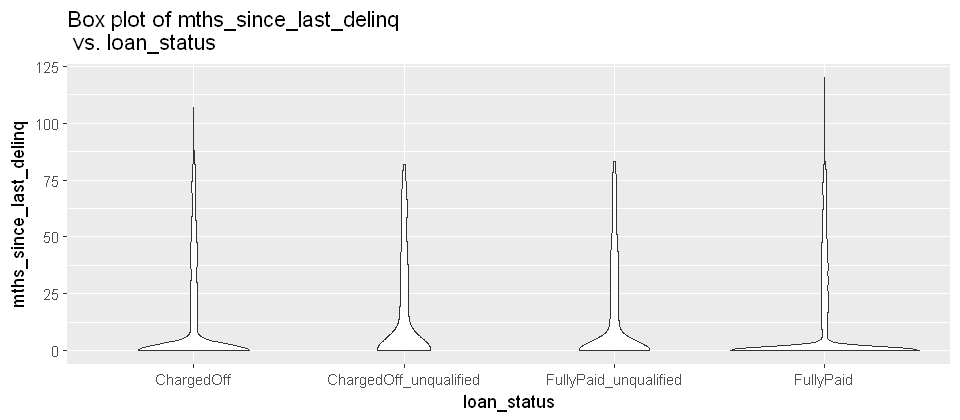

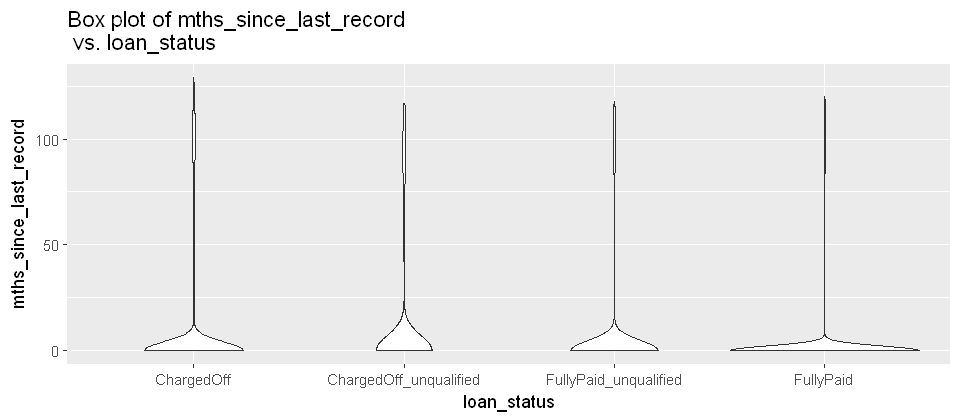

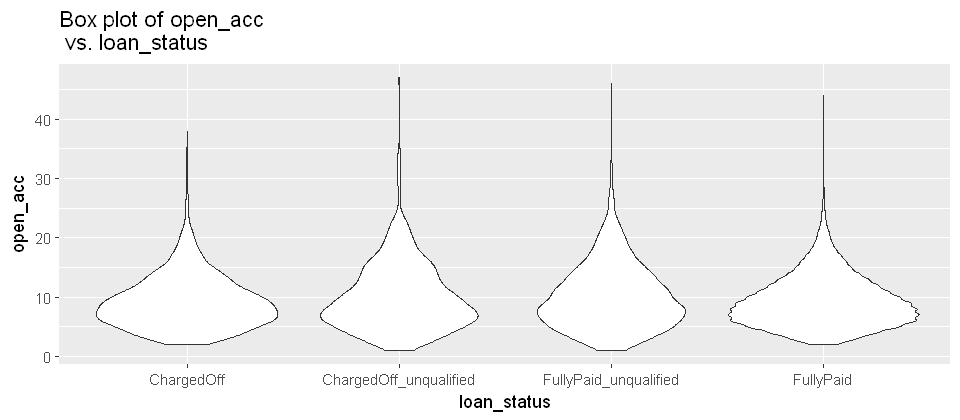

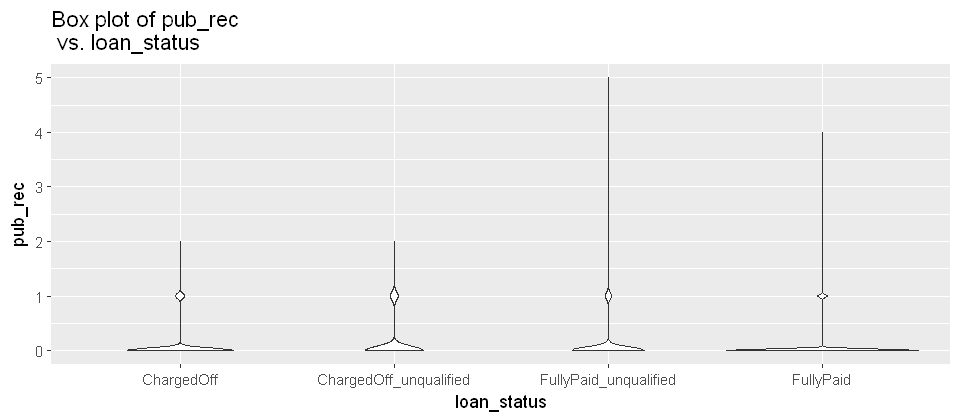

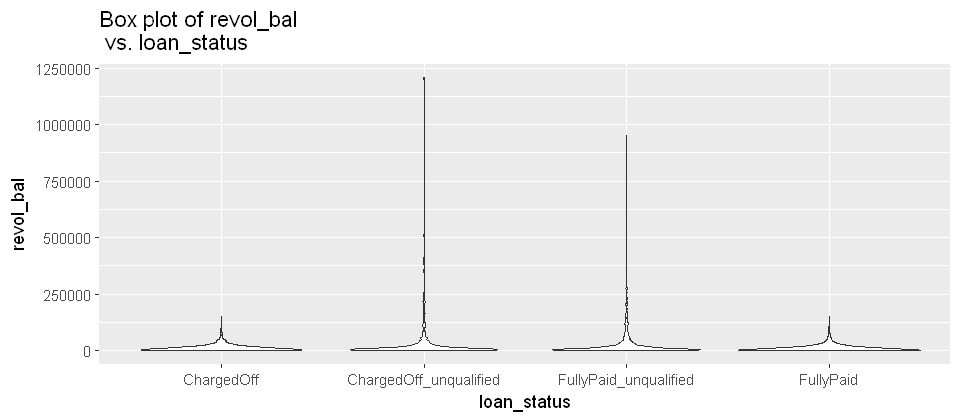

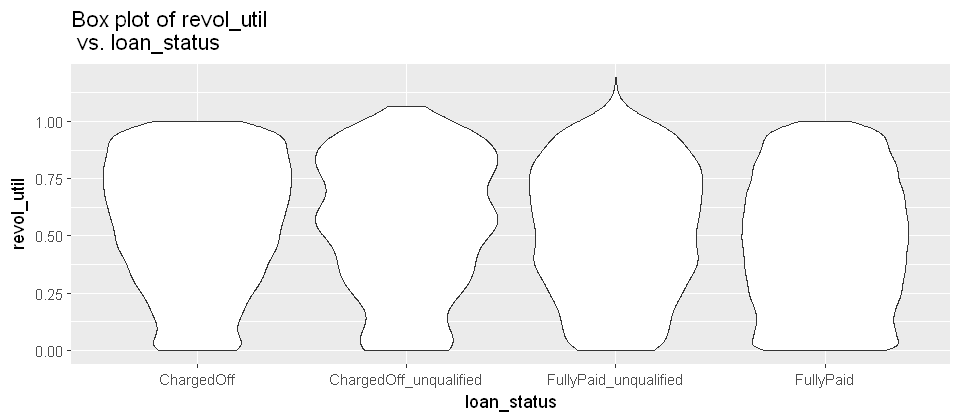

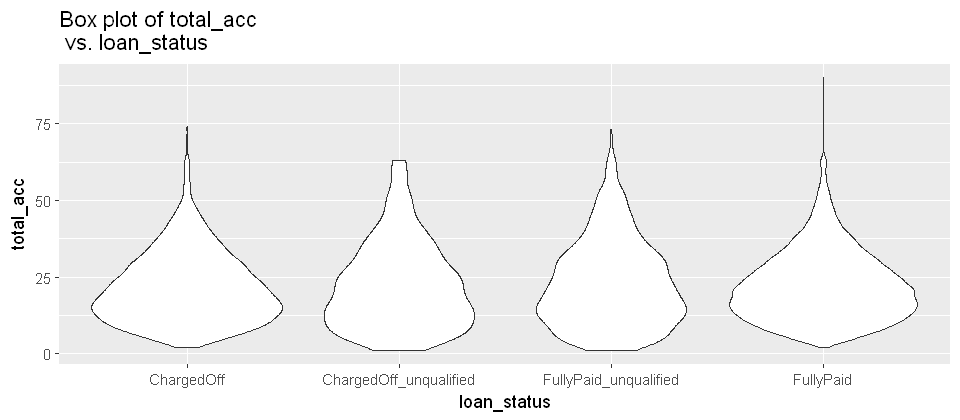

In [20]:
plot_violin = function(df, cols, col_x = 'loan_status'){
    options(repr.plot.width=8, repr.plot.height=3.5)
    for(col in cols){
        p = ggplot(df, aes_string(col_x, col))+
            geom_violin()+
            ggtitle(paste('Box plot of', col, '\n vs.', col_x))
        print(p)
    }
}

plot_violin(credit, num_cols)

According to the polts, I have some conclusion:

- The three features **loan_amnt**, **funded_amnt** and **funded_amnt_inv** have similar distributions, which means they are equivalent to seperate the class. So I only keep one of them.
- Many of the features provide enough evidence to seperate the qualified loan borrower and the borrower that cannot satisify the policy but get the loan any way. For example, the unqualified borrower inquires more time during the last 6 month than the qualified borrower, according to the feature **inq_last_6mths**.
- It is hard to seperate the chargedOff borrower and the fullyPaid borrower, but we still can see some faint evidence from the feature plots. For example, the charged borrower has a higher utiliztion perenctage of revolve and higher interest rate than the fully paid borrower, according to the feature **revlov_uti** and **int_rate**

### Vusualize class separation by categorical features

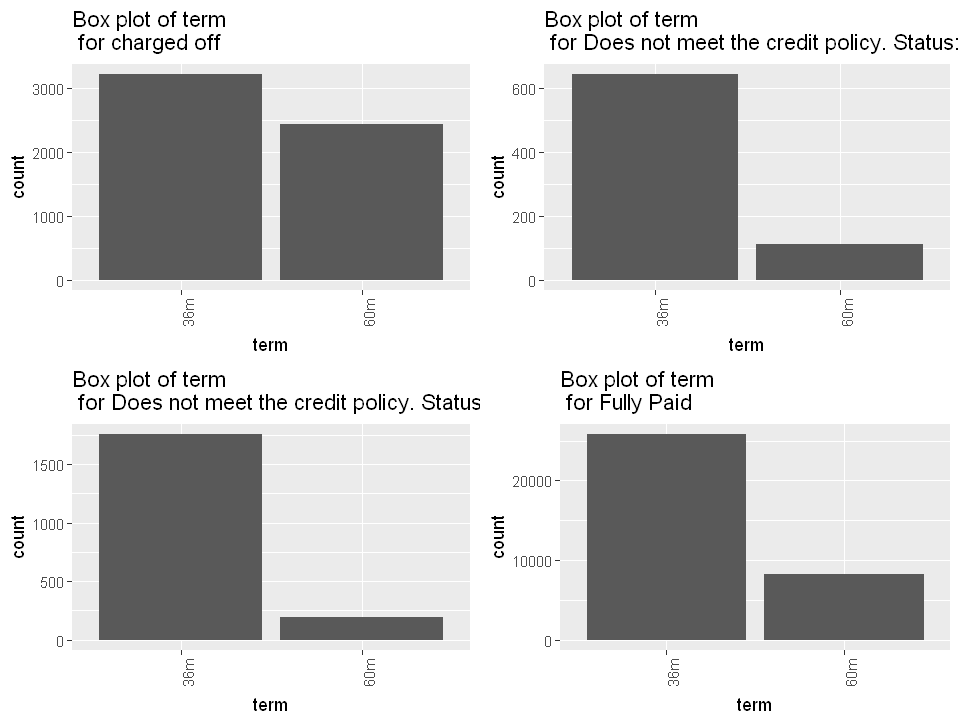

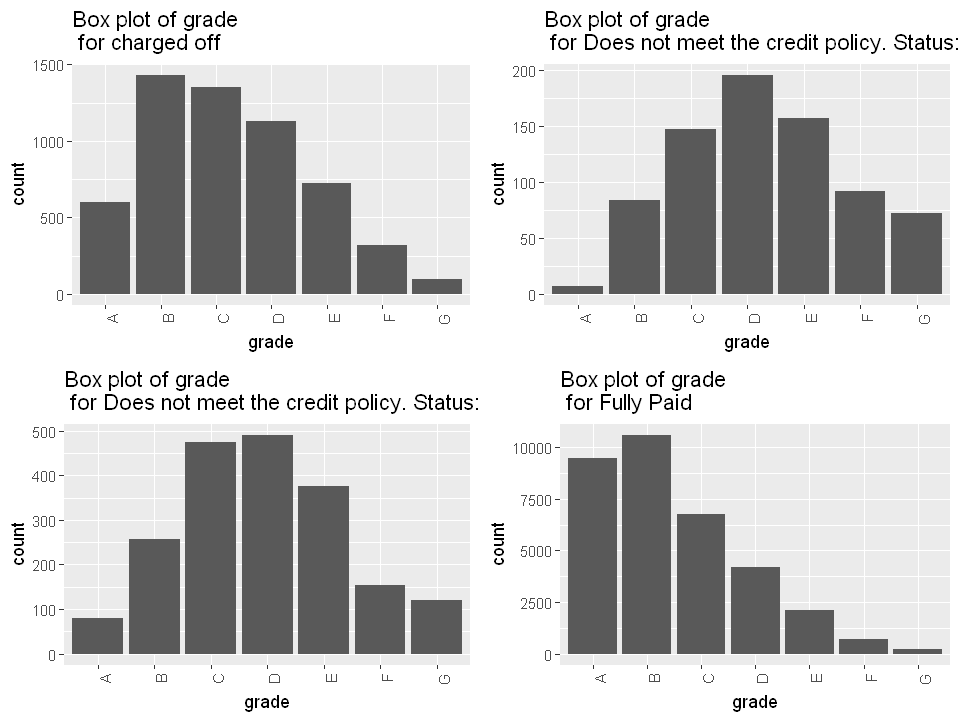

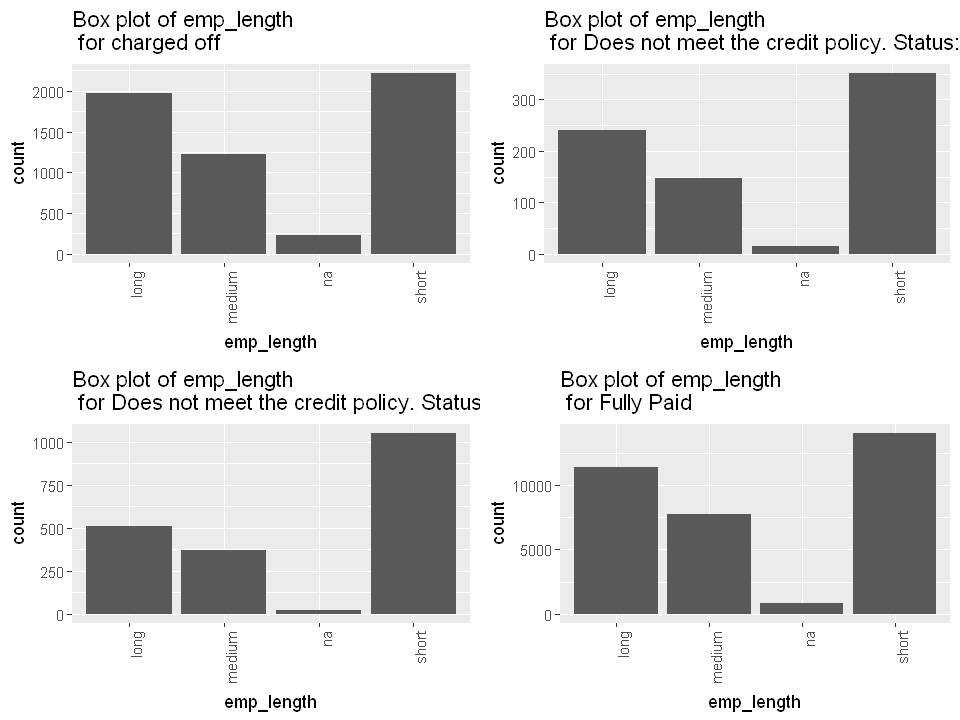

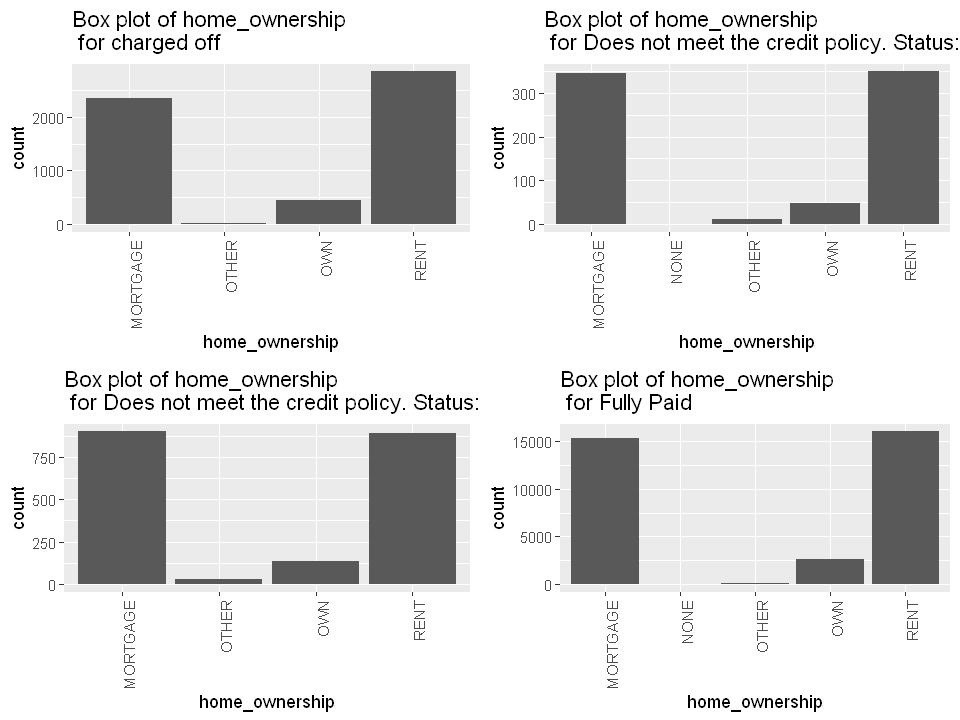

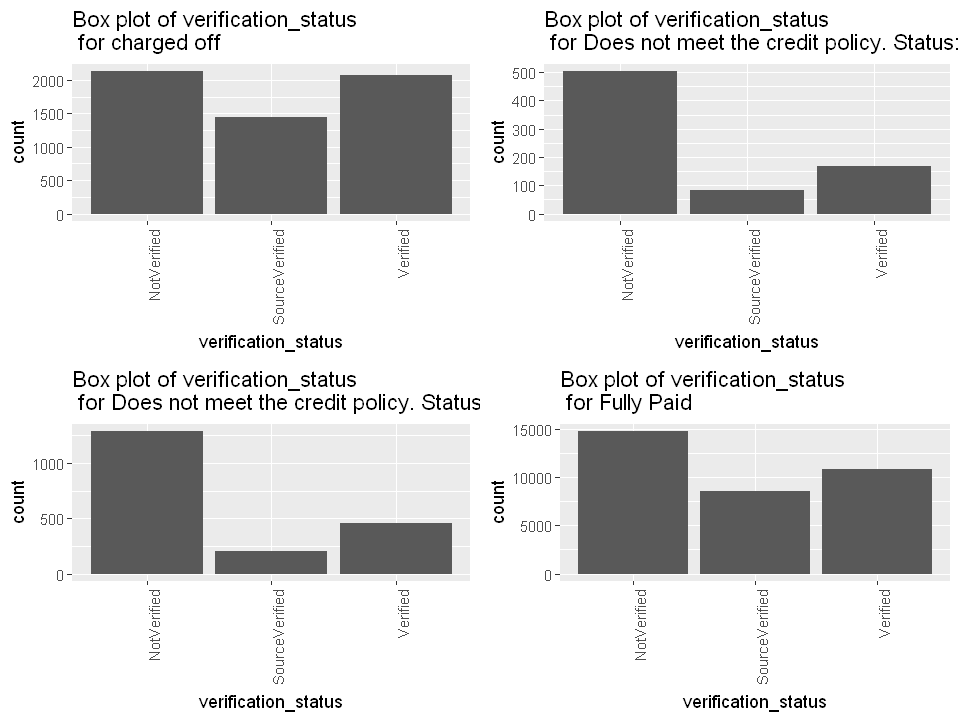

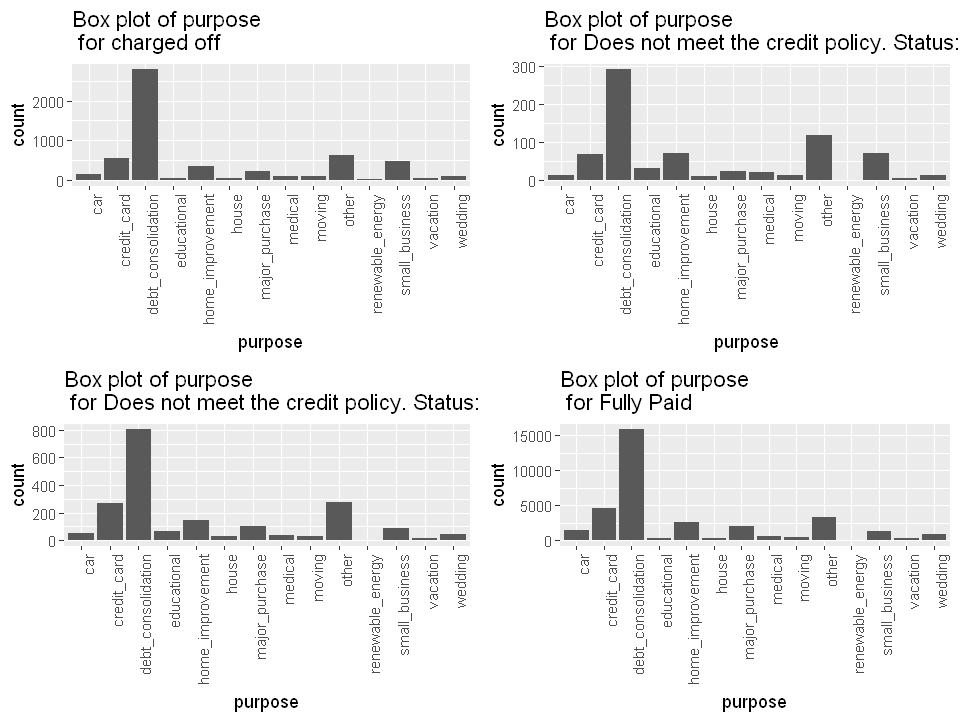

In [22]:
library(gridExtra)
plot_bars = function(de, catcols){
    options(repr.plot.width=8, repr.plot.height=6)
    temp1 = de[de$loan_status == 'ChargedOff',]
    temp2 = de[de$loan_status == 'ChargedOff_unqualified',]
    temp3 = de[de$loan_status == 'FullyPaid_unqualified',]
    temp4 = de[de$loan_status == 'FullyPaid' ,]
    for(col in catcols){
        p1 = ggplot(temp1, aes_string(col))+
            geom_bar()+
            ggtitle(paste('Box plot of', col, '\n for charged off'))+
            theme(axis.text.x = element_text(angle=90, hjus=1))
        p2 = ggplot(temp2, aes_string(col))+
            geom_bar()+
            ggtitle(paste('Box plot of', col, '\n for Does not meet the credit policy. Status:Charged Off'))+
            theme(axis.text.x = element_text(angle=90, hjus=1))
        p3 = ggplot(temp3, aes_string(col))+
            geom_bar()+
            ggtitle(paste('Box plot of', col, '\n for Does not meet the credit policy. Status:Fully Paid'))+
            theme(axis.text.x = element_text(angle=90, hjus=1))
        p4 = ggplot(temp4, aes_string(col))+
            geom_bar()+
            ggtitle(paste('Box plot of', col, '\n for Fully Paid'))+
            theme(axis.text.x = element_text(angle=90, hjus=1))
       grid.arrange(p1,p2,p3,p4, nrow=2)
    }
        
}

plot_bars(credit, categerical_cols)

From these plots, I get more information about how the categorical features seperate the different class of loan status.

- Some features such as **term** and **grade** have significantly different distribution of categories between the label categories.
- Others features such as **emp_length** show small differences, but these differences are unlikely to be significant.
- Other features like **home_ownership** have a dominant category with very few cases of other categories. These features will likely have very little power to separate the cases.
- The features **Porpose** show some potential to classier different loan status, but it has too many levels and hard to aggregate, so I decide to drop this feature.



# Step 4: Classification by Random Forest

### scale the numric datasets

In [69]:
preProcValues <- preProcess(credit[,num_cols], method = c("center", "scale"))
credit[,num_cols] = predict(preProcValues, credit[,num_cols])
str(credit)

'data.frame':	42444 obs. of  23 variables:
 $ loan_status           : Factor w/ 4 levels "Charged Off",..: 4 1 4 4 4 4 4 4 1 1 ...
 $ loan_amnt             : num  -0.824 -1.161 -1.174 -0.149 -1.093 ...
 $ funded_amnt           : num  -0.816 -1.166 -1.18 -0.117 -1.096 ...
 $ funded_amnt_inv       : num  -0.7266 -1.0738 -1.0878 -0.0218 -1.0036 ...
 $ term                  : Factor w/ 2 levels " 36 months"," 60 months": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate              : num  -0.408 0.838 1.024 0.358 0.142 ...
 $ installment           : num  -0.7663 -1.2595 -1.1422 0.0782 -1.2214 ...
 $ grade                 : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ emp_length            : Factor w/ 12 levels "< 1 year","1 year",..: 3 1 3 3 2 5 10 11 6 1 ...
 $ home_ownership        : Factor w/ 5 levels "MORTGAGE","NONE",..: 5 5 5 5 5 5 5 5 4 5 ...
 $ annual_inc            : num  -0.705 -0.611 -0.888 -0.312 0.169 ...
 $ verification_status   : Factor w/ 3 levels "Not Verified",..:

### Delete the useless features

In [24]:
cols_badfeatures <- c('loan_amnt','funded_amnt_inv','purpose')
credit[,cols_badfeatures] <- NULL
str(credit)

'data.frame':	42444 obs. of  20 variables:
 $ loan_status           : Factor w/ 4 levels "ChargedOff","ChargedOff_unqualified",..: 4 1 4 4 4 4 4 4 1 1 ...
 $ funded_amnt           : int  5000 2500 2400 10000 3000 5000 7000 3000 5600 5375 ...
 $ term                  : Factor w/ 2 levels "36m","60m": 1 2 1 1 2 1 2 1 2 2 ...
 $ int_rate              : num  0.106 0.153 0.16 0.135 0.127 ...
 $ installment           : num  162.9 59.8 84.3 339.3 67.8 ...
 $ grade                 : Factor w/ 7 levels "A","B","C","D",..: 2 3 3 3 2 1 3 5 6 2 ...
 $ emp_length            : chr  "long" "short" "long" "long" ...
 $ home_ownership        : Factor w/ 5 levels "MORTGAGE","NONE",..: 5 5 5 5 5 5 5 5 4 5 ...
 $ annual_inc            : num  24000 30000 12252 49200 80000 ...
 $ verification_status   : Factor w/ 3 levels "NotVerified",..: 3 2 1 2 2 2 1 2 2 3 ...
 $ dti                   : num  27.65 1 8.72 20 17.94 ...
 $ delinq_2yrs           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ inq_last_6mths        : int  

### Random Forest classification with a nested cross validation

Because the frequency of different loan_status are with great difference, to keep the classifiction with less bias I change the weights of each category.

Used 5 fold to find estimated optimal hyperparameters for a random forest model to classify credit risk cases. This process is the inner loop of a nested cross validation process. 

In [93]:
weights = ifelse(credit$loan_status == 'ChargedOff', 0.5, ifelse(credit$loan_status == 'ChargedOff_unqualified', 0.2,
            ifelse(credit$loan_status == 'FullyPaid_unqualified', 0.2,0.1)))

fitControl <- trainControl(method = "cv",
                           number = 5,
                           returnResamp="all",
                           savePredictions = TRUE,
                           classProbs = TRUE,
                           summaryFunction = multiClassSummary)
paramGrid <- expand.grid(mtry = c(5, 10, 15))

set.seed(1234)
rf_fit_inside_tw <- train(loan_status ~ ., 
                          data = credit,  
                          method = "rf", # Random forest model 
                          trControl = fitControl, 
                          tuneGrid = paramGrid, 
                          weights = weights)
print(rf_fit_inside_tw)

Random Forest 

42444 samples
   19 predictor
    4 classes: 'ChargedOff', 'ChargedOff_unqualifid', 'FullyPaid_unqualifid', 'FullyPaid' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 33957, 33955, 33954, 33955, 33955 
Resampling results across tuning parameters:

  mtry  logLoss    AUC        prAUC      Accuracy   Kappa      Mean_F1  
   5    0.4488683  0.8568449  0.5430274  0.8351946  0.3170668  0.4291800
  10    0.4474872  0.8554878  0.5432896  0.8345821  0.3234928  0.4406737
  15    0.4480758  0.8543578  0.5391335  0.8338753  0.3248210  0.4433442
  Mean_Sensitivity  Mean_Specificity  Mean_Pos_Pred_Value  Mean_Neg_Pred_Value
  0.455291          0.8124995         0.5553227            0.9388419          
  0.463889          0.8146829         0.5470822            0.9324415          
  0.465582          0.8153992         0.5445762            0.9287983          
  Mean_Precision  Mean_Recall  Mean_Detection_Rate  Mean_Balanced_Accuracy
  0.5553227      